In [1]:
!pip install pulp

# Installation de CBC (Coin-OR Branch and Cut)
!apt-get install -y -qq coinor-cbc
!apt-get install -y -qq glpk-utils


E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#données
dff = pd.read_csv("instance-2019-04-30.csv" , header = None)
dfff = dff.dropna(axis=0)
dfff.head()

,0,1,2,3,4
0,5217,CSC8088,20:30,4,D2
1,5218,CSC8802,20:25,4,D2
2,5219,CEB827,21:45,4,D2
3,5220,AFR291,10:30,5,E1
4,5221,KLM868,10:25,6,E1


In [4]:
array = dfff.to_numpy()[:5,:]
array

array([[5217, 'CSC8088', '20:30', 4, 'D2'],
       [5218, 'CSC8802', '20:25', 4, 'D2'],
       [5219, 'CEB827', '21:45', 4, 'D2'],
       [5220, 'AFR291', '10:30', 5, 'E1'],
       [5221, 'KLM868', '10:25', 6, 'E1']], dtype=object)

In [5]:
#Heure de decollage
h_dec =  array[:,2]
hvol = []
for i in range(h_dec.shape[0]):
    val = h_dec[i].split(":")
    time = int(val[0])*60 + int(val[1])
    hvol.append(time)
h_dec_min = np.array(hvol)
print(h_dec[:5])
h_dec_min[:5]


['20:30' '20:25' '21:45' '10:30' '10:25']


array([1230, 1225, 1305,  630,  625])

In [6]:
#id comptoire
Id_c = ['A1', 'A2','B1', 'B2','C1', 'C2','D1', 'D2','E1' ,'E2','F1','F2','G1', 'G2','H1','H2']
N_counter = np.arange(len(Id_c))

#Nbre de slot  demande
Nb_slot =list(array[:,3])

#vol
Vol_code = list(array[:,1])
Vol = np.arange(len(Vol_code))

#Preference des compagnie
Pref_c_code = list(array[:,4])
Pref_c = np.arange(len(Pref_c_code))

#Temps d'ouverture de comptoires
Open_time = list((h_dec_min - 150)/5)

#temps de fermerture de comptoire
Close_time = list((h_dec_min)/5)
Open =  [int(yy) for yy in Open_time]
Close =  [int(yy) for yy in Close_time]


#temps de liberation de certains comptoires
Open_time_L = list((h_dec_min - 45)/5)
Open_l =  [int(yy) for yy in Open_time_L]
Close =  [int(yy) for yy in Close_time]

#periodes
periode = np.arange (max (Close)+1 )

In [7]:
#intervalle d'enregistrement avec tout les comptoirs
intervales = [np.arange(a, b+1) for a, b in zip(   Open, Open_l)]

#intervalle d'enregistrement avec les comptoirs reduits
intervales_r = [np.arange(a+1, b+1) for a, b in zip(  Open_l, Close)]


#intervalle d'enregistrement
interv = [np.arange(a, b+1) for a, b in zip(  Open, Close)]

In [8]:
# matrice de cout
def set_val(c,L):
    n = len(L)
    tab = np.zeros(n)
    for s in L:
        if s == c:
            i = L.index(s)
            tab[i] = 0

            if i == n:
                for j in range(n-1, -1 , -1):
                    tab[j] = tab[j+1] + 1

            elif i == 0:
                for j in range(1,n):
                    tab[j] = tab[j-1] + 1
            else:
                for j in range(i-1, -1 , -1):
                    tab[j] = tab[j+1] + 1

                for j in range(i+1,n):
                    tab[j] = tab[j-1] + 1

    return tab

C = []
m = len(Pref_c_code)
for i in range(m):
    c = str(Pref_c_code[i])
    if (len(c) == 2):
        C.append(set_val(c,Id_c))
    else:
        C.append(set_val(c[0]+c[1],Id_c))
C = np.array(C)

In [9]:
len(Pref_c_code)

5

In [10]:
#Probleme

from pulp import lpDot, lpSum, \
     LpProblem, LpMinimize, \
     LpVariable, LpBinary, LpInteger


def get_problem_q1(**data):
    V = data['V']  # Liste des vols
    P = data['P']  # Liste des portes
    Cout = data['C']  # matrice des Coûts d'affectation
    D = data['Nb_slot']  # Ensemble de nombre de comptoirs demandés par les vols
    Interv = data['Interv']  # Intervalle d'enregistrement pour chaque compagnie (full)
    Intervals = data['Intervals']  # Intervalle d'enregistrement pour chaque compagnie (debut_full)
    Intervals_r = data['Intervals_r']  # Intervalle d'enregistrement pour chaque compagnie (restreint)
    periode = data ['Periode']



    # -- Création du problème
    problem = LpProblem("affectation de porte d'enregistrement - Le problème statique", LpMinimize)

    # -- Création des variables

    #x_ipt
    x = [[[LpVariable('x_{}_{}_{}'.format(i,p,t), cat=LpBinary) for t in periode] for p in P] for i in V]

    #y_ip
    y = [[LpVariable('y_{}_{}'.format(i,p), cat=LpBinary) for p in P] for i in V]


    # d_ipt
    d = [[[LpVariable('d_{}_{}_{}'.format(i,p,t), 0)  for t in periode]for p in P]for i in V]

    #z_iptc
    z = [[[[LpVariable('z_{}_{}_{}_{}'.format(i, p, t, c), cat=LpBinary) for c in range(12)] for t in periode] for p in P] for i in V]

    #u_ipc
    u = [[[LpVariable('u_{}_{}_{}'.format(i, p, c), cat=LpBinary) for c in range(12)] for p in P] for i in V]





    # -- Création de l'objectif
    problem += lpSum(((Cout[i][p]*x[i][p][t] for t in periode)  for p in P) for i in V)



    # -- Création des contraintes

    #une vol est assigné a une porte pendant toute la durée d'enregistrement
    for i in V:
        problem += lpSum((x[i][p][t] for t in Interv[i]) for p in P) == 31


    #un vol est assignée a une et une seule porte
    for i in V:
        problem += lpSum(y[i][p] for p in P) == 1


    #Pour une porte donnée, nous avons au plus 12 conptoir occupés à la foi
    for p in P:
        for t in periode:
            problem += lpSum(d[i][p][t] for i in V) <= 12


    # Nombre de comptoir qu'occupe un vol sur son premier interval (T_d) de temps d'enregistrement
    for i in V:
        for p in P:
            for t in Intervals[i]:
                problem += d[i][p][t] <= D[i]*x[i][p][t]
                problem += d[i][p][t] >= D[i]*x[i][p][t]

    # Nombre de comptoir qu'occupe un vol sur son dernier interval (T_r) de temps d'enregistrement
    for i in V:
        for p in P:
            for t in Intervals_r[i]:
                problem += d[i][p][t] <= x[i][p][t]
                problem += d[i][p][t] >= x[i][p][t]

    # Relation entre les variables x et y
    for i in V:
      for p in P:
        for t in interv[i]:
          problem += y[i][p] >= x[i][p][t]



    # Un vol occupe D[i] comptoirs lorsqu'il est affecté à une porte et un comptoir peut etre occupé par au plus un vol à la fois à chaque instant
    for i in V:
        for p in P:
            for t in Intervals[i]:
                problem += lpSum(z[i][p][t][c] for c in range(12)) == D[i] * x[i][p][t]
                for c in range(12):
                    problem += z[i][p][t][c] <= y[i][p]

    # Un vol occupe D[i] comptoirs lorsqu'il est affecté a une porte et un comptoir peut etre occupé par au plus un vol à la fois à chaque instant
    for i in V:
        for p in P:
            for t in Intervals_r[i]:
                problem += lpSum(z[i][p][t][c] for c in range(12)) == x[i][p][t]
                for c in range(12):
                    problem += z[i][p][t][c] <= y[i][p]

    # un vol occupe les memes comptoirs pendant son premier interval de temps d'enregistrement
    for i in V:
        for p in P:
           for c in range(1, 12):
             for t in Intervals[i]:
                for k in Intervals[i]:
                    problem += z[i][p][t][c] == z[i][p][k][c]

    # Un vol a un numero de debut de comptoirs occupés par sur une porte
    for i in V:
      problem += lpSum((u[i][p][c] for p in P )for c in range (12-D[i]+1))==1

    # les comptoirs occupés par un vol sont adjacents
    for i in V:
      for p in P:
        for t in Intervals[i]:
          for c in range(12-D[i]+1):
            for k in range (c , c + D[i]):
              problem +=  z[i][p][t][k] >= u[i][p][c]


    # le comptoir occupé pendant les 45 dernieres minutes est l'un des comptoirs occupés sur le premier  d'enregistrement
    for i in V:
      for p in P:
        for t in Intervals_r[i]:
          for c in range(12-D[i]+1):
            for k in range (c , c + 1):
              problem +=  z[i][p][t][k] >= u[i][p][c]


    # un comptoir peut etre le premier des comptoirs occupés d'au plus un vol a la fois
    for p in P:
      for t in periode:
        for c in range(12):
           problem +=  lpSum( u[i][p][c] for i in V) <=1
           problem += lpSum (z[i][p][t][c] for i in V) <=1



    return problem

In [11]:
# resolution
import pulp
data = {'V': Vol, 'P': N_counter, 'Open_time': Open, 'Close_time': Close, 'C': C, 'Nb_slot': Nb_slot,'Interv':interv, 'Intervals':intervales,'Intervals_r':intervales_r, 'Periode':periode}
problem = get_problem_q1(**data)
status = problem.solve(pulp.PULP_CBC_CMD(msg=True,timeLimit=3600))


/home/mtds/anaconda3/lib/python3.11/site-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/mtds/anaconda3/lib/python3.11/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/04de811516e44fc796e4213721d8fa57-pulp.mps sec 3600 timeMode elapsed branch printingOptions all solution /tmp/04de811516e44fc796e4213721d8fa57-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 643348 COLUMNS
At line 2819937 RHS
At line 3463281 BOUNDS
At line 3735647 ENDATA
Problem MODEL has 643343 rows, 293325 columns and 1592848 elements
Coin0008I MODEL read with 0 errors
seconds was changed from 1e+100 to 3600
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 2.10 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 7957 strengthened rows, 36364 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 8491 strengthened rows, 54 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 8489 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 847

In [15]:
# Afficher des solutions
print("Statut:", pulp.LpStatus[problem.status])
solving_time = problem.solutionTime
print("Temps de résolution:", solving_time, "secondes")
print("Valeur de la fonction objectif:", pulp.value(problem.objective),"\n\n")
print("Valeurs des variables:")
integer_vars = {}
for var in problem.variables():
    integer_vars[var.name] = int(var.varValue)
non_zero_integer_vars = {key: value for key, value in integer_vars.items() if value != 0}
# Afficher les valeurs des variables
#print(non_zero_integer_vars)

Statut: Optimal
Temps de résolution: 44.69062614440918 secondes
Valeur de la fonction objectif: 0.0 


Valeurs des variables:


In [16]:
#visualisation des solutions

# Parcourir le dictionnaire initial et distribuer les valeurs en fonction du type de clé
d_keys = {}
x_keys = {}
y_keys = {}
z_keys = {}
for key, value in non_zero_integer_vars.items():
    if key.startswith('d_'):
        d_keys[key] = value
    elif key.startswith('y_'):
      y_keys[key] = value
    elif key.startswith('x_'):
        x_keys[key] = value
    elif key.startswith('z_'):
          z_keys[key] = value

# Fonction pour extraire le chiffre entre les deux '_'
def extract_number(key):
    return int(key.split('_')[1])

# Trier le dictionnaire en fonction du chiffre extrait
sorted_d_keys = {key: value for key, value in sorted(d_keys.items(), key=lambda x: extract_number(x[0]))}
sorted_y_keys = {key: value for key, value in sorted(y_keys.items(), key=lambda x: extract_number(x[0]))}
sorted_x_keys = {key: value for key, value in sorted(x_keys.items(), key=lambda x: extract_number(x[0]))}
sorted_z_keys = {key: value for key, value in sorted(z_keys.items(), key=lambda x: extract_number(x[0]))}

# Afficher le dictionnaire trié
print(sorted_d_keys,"\n\n")
print(sorted_y_keys,"\n\n")
print(sorted_x_keys,"\n\n")
print(sorted_z_keys,"\n\n")

dictionnaires = {}
dictionnaire_en_cours = None

# Découpage et regroupement des éléments dans les dictionnaires
for cle, valeur in sorted_z_keys.items():
  indice_z = cle.split('_')[1]  # Obtention du premier indice z
  if indice_z not in dictionnaires:  # Si le dictionnaire pour cet indice z n'existe pas
      dictionnaire_en_cours = {}  # Création d'un nouveau dictionnaire
      dictionnaires[indice_z] = dictionnaire_en_cours  # Ajout du dictionnaire au dictionnaire global
  dictionnaire_en_cours[cle] = valeur  # Ajout de l'élément au dictionnaire correspondant

{'d_0_7_216': 4, 'd_0_7_217': 4, 'd_0_7_218': 4, 'd_0_7_219': 4, 'd_0_7_220': 4, 'd_0_7_221': 4, 'd_0_7_222': 4, 'd_0_7_223': 4, 'd_0_7_224': 4, 'd_0_7_225': 4, 'd_0_7_226': 4, 'd_0_7_227': 4, 'd_0_7_228': 4, 'd_0_7_229': 4, 'd_0_7_230': 4, 'd_0_7_231': 4, 'd_0_7_232': 4, 'd_0_7_233': 4, 'd_0_7_234': 4, 'd_0_7_235': 4, 'd_0_7_236': 4, 'd_0_7_237': 4, 'd_0_7_238': 1, 'd_0_7_239': 1, 'd_0_7_240': 1, 'd_0_7_241': 1, 'd_0_7_242': 1, 'd_0_7_243': 1, 'd_0_7_244': 1, 'd_0_7_245': 1, 'd_0_7_246': 1, 'd_1_7_215': 4, 'd_1_7_216': 4, 'd_1_7_217': 4, 'd_1_7_218': 4, 'd_1_7_219': 4, 'd_1_7_220': 4, 'd_1_7_221': 4, 'd_1_7_222': 4, 'd_1_7_223': 4, 'd_1_7_224': 4, 'd_1_7_225': 4, 'd_1_7_226': 4, 'd_1_7_227': 4, 'd_1_7_228': 4, 'd_1_7_229': 4, 'd_1_7_230': 4, 'd_1_7_231': 4, 'd_1_7_232': 4, 'd_1_7_233': 4, 'd_1_7_234': 4, 'd_1_7_235': 4, 'd_1_7_236': 4, 'd_1_7_237': 1, 'd_1_7_238': 1, 'd_1_7_239': 1, 'd_1_7_240': 1, 'd_1_7_241': 1, 'd_1_7_242': 1, 'd_1_7_243': 1, 'd_1_7_244': 1, 'd_1_7_245': 1, 'd_2_7_

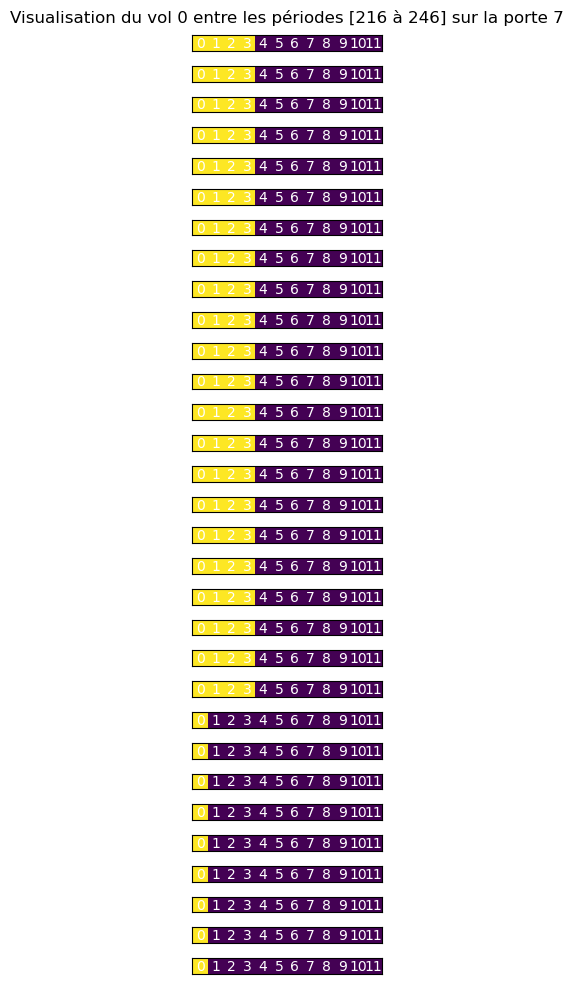

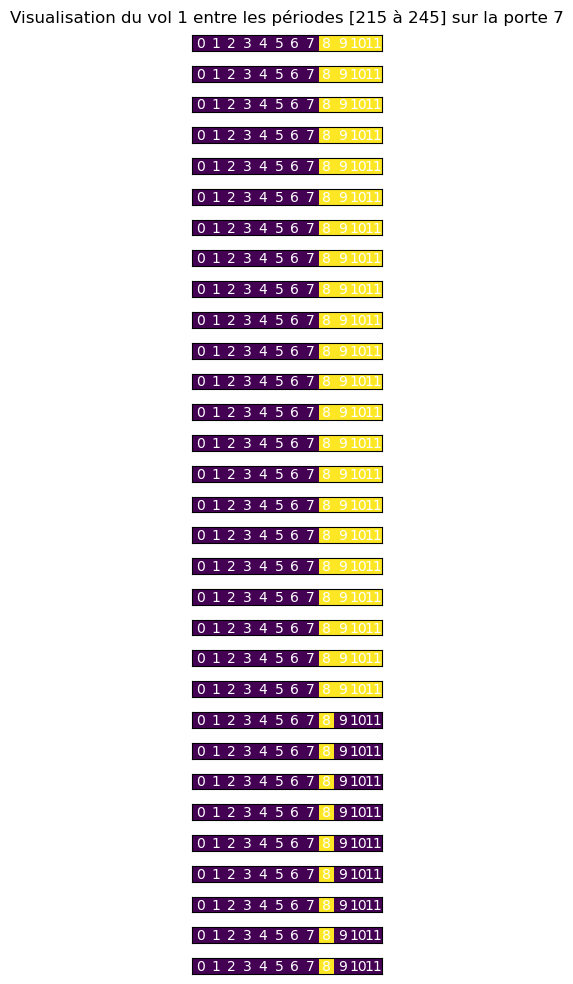

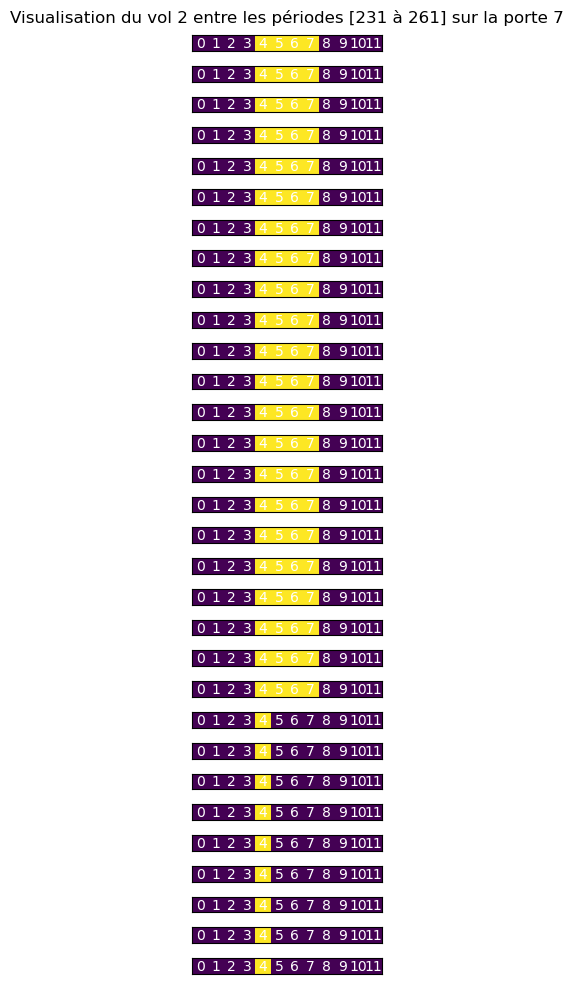

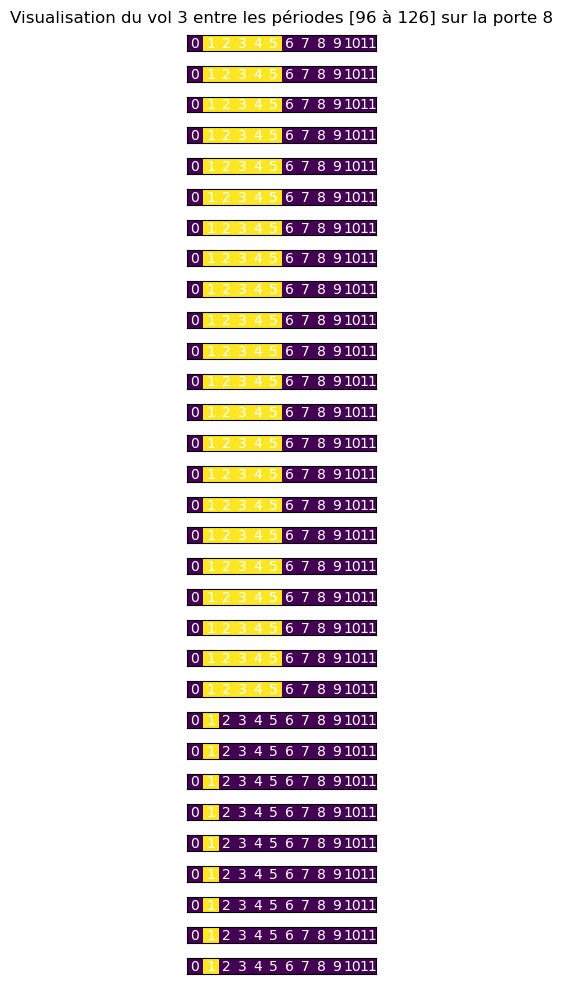

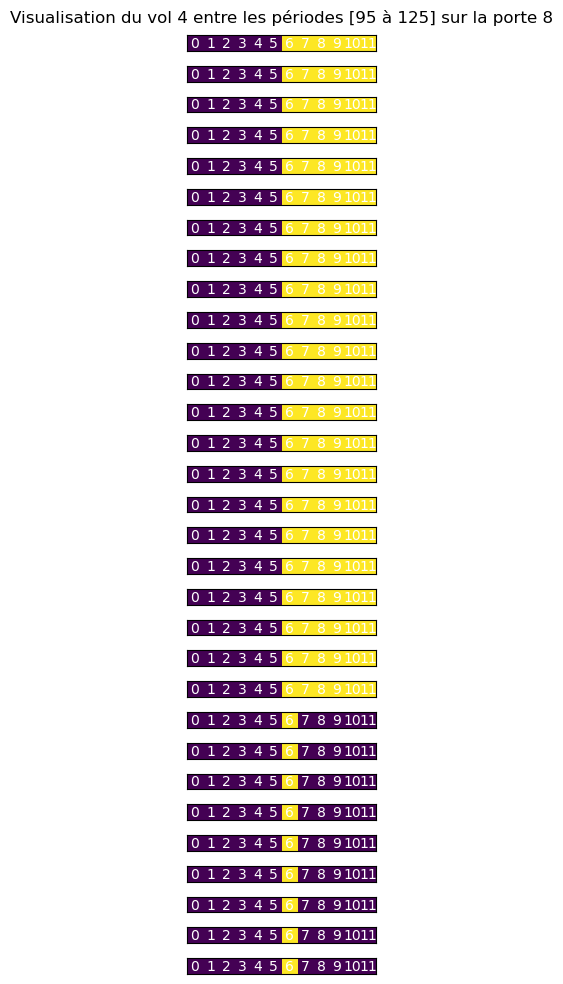

In [17]:
#visualisation
for indice_z,dictionnaire in dictionnaires.items():
  vols = dictionnaire
  #print (vols)

  # Extraction des périodes et des portes
  Periodes = set()
  portes = set()


  for vol in vols:
      _, _, porte, Periode, z = vol.split('_')
      portes.add(int(porte))
      Periodes.add(int(Periode))

  # Création de la grille
  grille = [[[0 for _ in range(12)] for _ in range(len(portes))] for _ in range(len(Periodes))]

  # Placement des vols dans la grille
  for vol, comptoir in vols.items():
      _, _, porte, Periode, z = vol.split('_')
      grille[int(Periode) - min(Periodes)][int(porte) - min(portes)][int(z)] = comptoir

  # Récupération de la première et de la dernière période
  pp = min(Periodes)
  dp = max(Periodes)


  # Création du graphique
  plt.figure(figsize=(12,10))


  # Récupérer le numéro du vol et de la porte pour le titre principal
  num_vol = list(vols.keys())[0].split('_')[1]
  num_porte = list(vols.keys())[0].split('_')[2]

  # Affichage de chaque grille
  for i, Periode in enumerate(sorted(Periodes)):
    #if (Periode == pp or Periode == dp ):
        for j, porte in enumerate(sorted(portes)):
            plt.subplot(len(Periodes), len(portes), i * len(portes) + j + 1)
            plt.imshow([grille[i][j]], cmap='viridis')
            plt.xticks([])
            plt.yticks([])
            for k in range(12):
                plt.text(k, 0, str(k), color='white', ha='center', va='center') # Ajout du numéro de comptoir


  plt.suptitle(f'Visualisation du vol {num_vol} entre les périodes [{pp} à {dp}] sur la porte {num_porte}')
  plt.tight_layout()
  plt.show()

